In [1]:
import zipfile
import gc
import copy
import pickle
import time
import scipy
import cv2
import torch
import torchvision
import faiss

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import seaborn as sns

from tqdm import tqdm
from pathlib import Path
from barbar import Bar
from ast import literal_eval
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from utils import display_image

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
index_df = pd.read_csv('./index_df.csv')

In [4]:
index_df.head(1)

,filename,category,label_id,embeddings
0,./index_images/4095f53b27865649ae4be89e739f1de...,Shirts,2,"[2.123265027999878, 4.5380730628967285, 0.0, 5..."


In [5]:
with open("embeddings.pkl", "rb") as file:
    embeddings = pickle.load(file)

In [6]:
embeddings[0].shape

(512,)

In [10]:
labels = index_df['category'].tolist()

In [11]:
len(labels)

12225

In [12]:
shirt_df = index_df[index_df['category'] == 'Shirts'].copy()

In [16]:
shirt_df['embeddings'] = shirt_df['embeddings'].apply(lambda x: torch.FloatTensor(x))
shirt_emb = np.array(shirt_df['embeddings']).tolist()

In [ ]:
shirt_emb[0]

In [28]:
class ExactIndex():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels
        self.build()

    def build(self):
        self.index = faiss.IndexFlatL2(self.dimension)
        self.index.add(self.vectors)

    def query(self, vectors, k=10):
        distances, indices = self.index.search(vectors, k)
        return [self.labels[i] for i in indices[0]]
    
    def save(self, filename):
        faiss.write_index(self.index, filename)
    
    @classmethod
    def load(cls, vectors, labels, filename):
        instance = cls(vectors, labels)
        instance.index = faiss.read_index(filename)
        return instance


In [29]:
flatIndex = ExactIndex(embeddings, labels)
flatIndex.build

<bound method ExactIndex.build of <__main__.ExactIndex object at 0x2b3f7cdf0>>

Test Function on one item

In [31]:
query_vector = shirt_emb[0]
query_vector = query_vector.reshape(1, -1)
selected_nn = flatIndex.query(query_vector, k=5)
selected_nn

['Shirts', 'Handbags', 'Hats', 'Scarves', 'Shirts']

In [32]:
true_p = 0
false_p = 0

for i in selected_nn:
    if i == 'Shirts':
        true_p += 1
    else:
        false_p += 1

p_5 = true_p / (true_p + false_p)

0.4

In [34]:
total_p5_shirt = []

for q_vector in shirt_emb:
    q_vector = q_vector.reshape(1, -1)
    selected_nn = flatIndex.query(q_vector, k=5)
    t_p = sum(1 for i in selected_nn if i == 'Shirts')
    f_p = len(selected_nn) - t_p
    p_5 = t_p / (t_p + f_p)
    total_p5_shirt.append(p_5)

mean_p5_shirt = sum(total_p5_shirt) / len(total_p5_shirt)
print(f"mAP @ 5 for shirt: {mean_p5_shirt}")

mAP @ 5 for shirt: 0.5289999999999984


Calculate mAP@5 for all categories

In [35]:
# Convert embeddings to float tensors
index_df['embeddings'] = index_df['embeddings'].apply(lambda x: torch.FloatTensor(x))

# Get unique categories
unique_categories = index_df['category'].unique()

# Initialize a dictionary to store mean_p5 for each category
mean_p5_dict = {}

# Loop through each category
for category in unique_categories:
    # Filter the df for the current category
    category_df = index_df[index_df['category'] == category].copy()

    # Convert embeddings to a list of np arrays
    category_emb = np.array(category_df['embeddings']).tolist()

    # Calculate mAP@5 for the current category
    total_p5_category = []
    for q_vector in category_emb:
        q_vector = q_vector.reshape(1, -1)
        selected_nn = flatIndex.query(q_vector, k=5)
        t_p = sum(1 for i in selected_nn if i == category)
        f_p = len(selected_nn) - t_p
        p_5 = t_p / (t_p + f_p)
        total_p5_category.append(p_5)

    # Calculate the mean_p5 for the current category
    mean_p5_category = sum(total_p5_category) / len(total_p5_category)

    # Store the mean_p5 in the dict
    mean_p5_dict[category] = mean_p5_category

# Calculate overall mean_p5
overall_mean_p5 = sum(mean_p5_dict.values()) / len(mean_p5_dict)

# Print results
for category, mean_p5_category in mean_p5_dict.items():
    print(f"mAP @ 5 for {category}: {mean_p5_category}")

print(f"Overall mAP@5: {overall_mean_p5}")

mAP @ 5 for Shirts: 0.5289999999999984
mAP @ 5 for Rings: 0.33731343283582066
mAP @ 5 for Jewelry: 0.6257999999999996
mAP @ 5 for Dresses: 0.6354
mAP @ 5 for Handbags: 0.6281999999999995
mAP @ 5 for Shoes: 0.6865999999999993
mAP @ 5 for Skirts: 0.6539999999999999
mAP @ 5 for Hats: 0.6876000000000004
mAP @ 5 for Coats: 0.5966000000000005
mAP @ 5 for Sunglasses: 0.8712389380530967
mAP @ 5 for Belts: 0.3544303797468351
mAP @ 5 for Pants: 0.8681999999999997
mAP @ 5 for Shorts: 0.7206786850477197
mAP @ 5 for Watches: 0.821189591078067
mAP @ 5 for Scarves: 0.5427046263345185
mAP @ 5 for Socks: 0.3186440677966098
mAP @ 5 for Jumpsuits: 0.29677419354838713
mAP @ 5 for Swimwear: 0.3565217391304348
mAP @ 5 for Stockings: 0.225
mAP @ 5 for Gloves: 0.19999999999999998
mAP @ 5 for Neckties: 0.2
Overall mAP@5: 0.5312331263605469


In [36]:
mean_p5_dict['Overall'] = np.mean(list(mean_p5_dict.values()))
map5_result = pd.DataFrame(list(mean_p5_dict.items()), columns=['Category', 'mAP@5'])
map5_result

,Category,mAP@5
0,Shirts,0.529000
1,Rings,0.337313
2,Jewelry,0.625800
3,Dresses,0.635400
4,Handbags,0.628200
5,Shoes,0.686600
6,Skirts,0.654000
7,Hats,0.687600
8,Coats,0.596600
9,Sunglasses,0.871239


In [37]:
map5_result.to_csv('map5_result.csv', index=False)

In [7]:
map5_result = pd.read_csv('./map5_result.csv')

In [11]:
# Find the index of the row where 'Category' is 'Overall'
index_to_rename = map5_result[map5_result['Category'] == 'Overall'].index[0]

# Rename the cell
map5_result.at[index_to_rename, 'Category'] = 'All'

In [12]:
map5_result = map5_result.sort_values(by='Category')

In [13]:
map5_result

,Category,mAP@5
21,All,0.531233
10,Belts,0.354430
8,Coats,0.596600
3,Dresses,0.635400
19,Gloves,0.200000
4,Handbags,0.628200
7,Hats,0.687600
2,Jewelry,0.625800
16,Jumpsuits,0.296774
20,Neckties,0.200000


In [8]:
import seaborn as sns

/Users/joankusuma/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joankusuma/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joankusuma/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


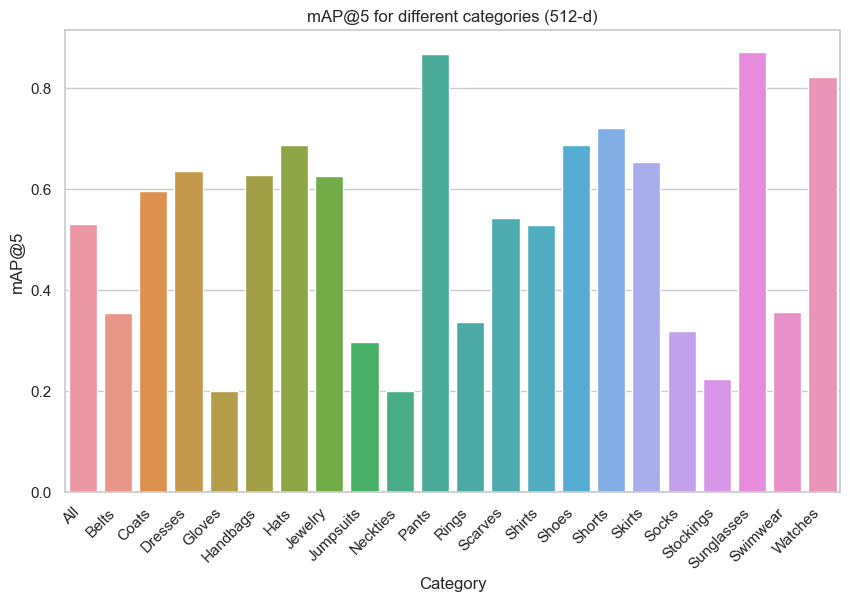

In [14]:
# Visualize plot
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y="mAP@5", data=map5_result)
plt.xticks(rotation=45, ha='right')
plt.title('mAP@5 for different categories (512-d)')
plt.show()

In [2]:
index_df = pd.read_csv('./index_df.csv')
index_df.head()

,filename,category,label_id,embeddings
0,./index_images/4095f53b27865649ae4be89e739f1de...,Shirts,2,"[2.123265027999878, 4.5380730628967285, 0.0, 5..."
1,./index_images/2a4c9a21b6302fb76ae9aa28235094b...,Shirts,2,"[2.659057855606079, 3.771310567855835, 1.27047..."
2,./index_images/bfcc15c4bd74347bb6336d266ace2a7...,Shirts,2,"[0.3487861454486847, 4.077633380889893, 2.0920..."
3,./index_images/cf880237d3e9683803d4a8a23fa456d...,Shirts,2,"[0.9752116799354553, 0.0, 1.9928834438323975, ..."
4,./index_images/d02f63672742c9efd5838017f46931f...,Shirts,2,"[12.112330436706543, 2.8348710536956787, 7.798..."


In [4]:
cat_counts = index_df['category'].value_counts().reset_index()
cat_counts.columns = ['category', 'count']
cat_counts = cat_counts.sort_values(by='category')
cat_counts

,category,count
13,Belts,79
7,Coats,1000
2,Dresses,1000
18,Gloves,10
3,Handbags,1000
6,Hats,1000
1,Jewelry,1000
16,Jumpsuits,31
20,Neckties,1
8,Pants,1000


/Users/joankusuma/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joankusuma/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joankusuma/miniconda3/envs/ml/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


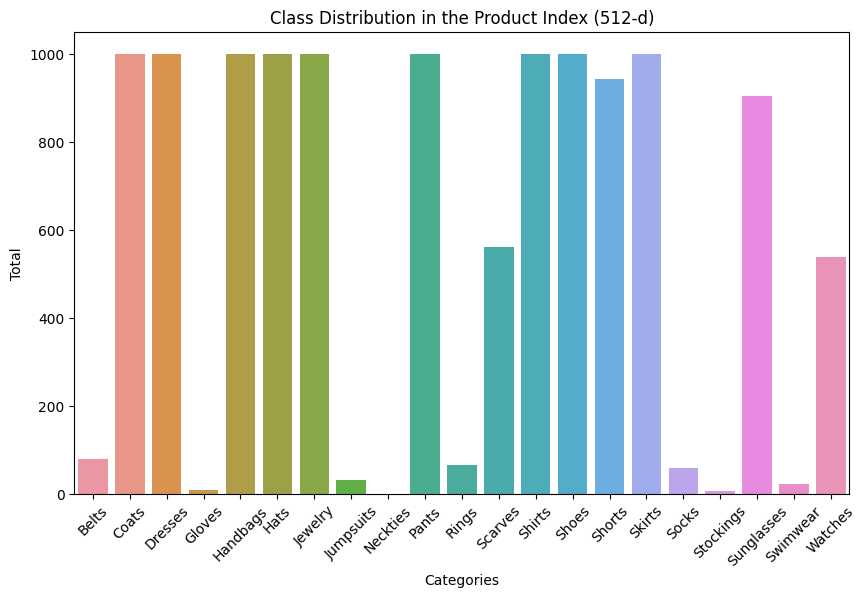

In [6]:
# Visualize count
plt.figure(figsize=(10, 6))
sns.barplot(data=cat_counts, x='category', y='count')
plt.xlabel('Categories')
plt.ylabel('Total')
plt.title('Class Distribution in the Product Index (512-d)')
plt.xticks(rotation=45)
plt.show()